In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm

from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
ls

'Analisis Mulai dari Kanan.ipynb'   SUKSES_CONTROL_MULAI_AGA_KANAN.bag
'Analisis Mulai dari Kiri.ipynb'    SUKSES_CONTROL_MULAI_AGA_KIRI.bag
 images/                            WAYPOINTS_I_4.npy
'INI GATAU APA.bag'


# IMPORT DATA

In [3]:
wp = np.load('WAYPOINTS_I_4.npy')

In [4]:
bag = rosbag.Bag('SUKSES_CONTROL_MULAI_AGA_KANAN.bag')

## DATA CONTROL

In [5]:
cs_t = []
cs_action_steer = []
cs_action_throttle = []
cs_action_brake = []
cs_error_lateral = []
cs_error_yaw = []
cs_error_speed = []
cs_actual_x = []
cs_actual_y = []
cs_actual_yaw = []
cs_actual_speed = []
cs_wp_idx = []
cs_ref_x = []
cs_ref_y = []
cs_ref_yaw = []
cs_ref_speed = []
cs_ref_curvature = []

for topic, msg, _ in bag.read_messages(topics=['/control_signal']):
    cs_t.append(msg.header.stamp.to_sec())
    cs_action_steer.append(msg.action_steer)
    cs_action_throttle.append(msg.action_throttle)
    cs_action_brake.append(msg.action_brake)
    cs_error_lateral.append(msg.error_lateral)
    cs_error_yaw.append(msg.error_yaw)
    cs_error_speed.append(msg.error_speed)
    cs_actual_x.append(msg.actual_x)
    cs_actual_y.append(msg.actual_y)
    cs_actual_yaw.append(msg.actual_yaw)
    cs_actual_speed.append(msg.actual_speed)
    cs_wp_idx.append(msg.wp_idx)
    cs_ref_x.append(msg.ref_x)
    cs_ref_y.append(msg.ref_y)
    cs_ref_yaw.append(msg.ref_yaw)
    cs_ref_speed.append(msg.ref_speed)
    cs_ref_curvature.append(msg.ref_curvature)

cs_t = np.array(cs_t)
cs_action_steer = np.array(cs_action_steer)
cs_action_throttle = np.array(cs_action_throttle)
cs_action_brake = np.array(cs_action_brake)
cs_error_lateral = np.array(cs_error_lateral)
cs_error_yaw = np.array(cs_error_yaw)
cs_error_speed = np.array(cs_error_speed)
cs_actual_x = np.array(cs_actual_x)
cs_actual_y = np.array(cs_actual_y)
cs_actual_yaw = np.array(cs_actual_yaw)
cs_actual_speed = np.array(cs_actual_speed)
cs_wp_idx = np.array(cs_wp_idx)
cs_ref_x = np.array(cs_ref_x)
cs_ref_y = np.array(cs_ref_y)
cs_ref_yaw = np.array(cs_ref_yaw)
cs_ref_speed = np.array(cs_ref_speed)
cs_ref_curvature = np.array(cs_ref_curvature)

## Data Arduino

In [6]:
a_t = []
a_steering_setpoint = []
a_steering_angle = []
a_throttle_voltage = []
for topic, msg, _ in bag.read_messages(topics=['/logging_arduino']):
    a_t.append(msg.header.stamp.to_sec())
    a_steering_setpoint .append(msg.steering_setpoint )
    a_steering_angle.append(msg.steering_angle)
    a_throttle_voltage.append(msg.throttle_voltage)
a_t = np.array(a_t)
a_steering_setpoint = np.array(a_steering_setpoint)
a_steering_angle = np.array(a_steering_angle)
a_throttle_voltage = np.array(a_throttle_voltage)

## DATA GPS STATE ESTIMATION

In [7]:
x = []
y = []
vx = []
vy = []
ax = []
ay = []
yaw = []
w = []
t = []
for topic, msg, _ in bag.read_messages(topics=['/gps_state_estimation']):
    t.append(msg.header.stamp.to_sec())
    x.append(msg.x)
    y.append(msg.y)
    vx.append(msg.vx)
    vy.append(msg.vy)
    ax.append(msg.ax)
    ay.append(msg.ay)
    yaw.append(msg.yaw)
    w.append(msg.w)
x = np.array(x)
y = np.array(y)
vx = np.array(vx)
vy = np.array(vy)
ax = np.array(ax)
ay = np.array(ay)
yaw = np.array(yaw)
w = np.array(w)
t = np.array(t)

## DATA GPS ASLI

In [8]:
lat0, lon0, h0 = -6.8712, 107.5738, 768
gps_t = []
gps_pos = []
gps_cov = []
for topic, msg, _ in bag.read_messages(topics=['/fix']):
    gps_t.append(msg.header.stamp.to_sec())
    gps_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
    gps_cov.append(msg.position_covariance)
gps_t = np.array(gps_t)
gps_pos = np.array(gps_pos)
gps_cov = np.array(gps_cov).reshape(-1,3,3)

# Ambil yang bagus-bagus aja
gnss_pos = np.copy(gps_pos[:-1])
gnss_t = np.copy(gps_t[:-1])
gnss_cov = np.copy(gps_cov[:-1])

gps_pos = (-1) * np.copy(gnss_pos[:,:2])
gps_t = np.copy(gnss_t)

# PLOT

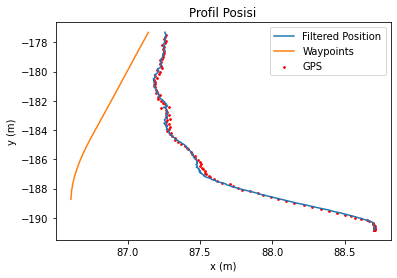

In [9]:
plt.scatter(gps_pos[:,0], gps_pos[:,1], label='GPS', s=3., color='red')
plt.plot(cs_actual_x, cs_actual_y, label='Filtered Position')
plt.plot(cs_ref_x, cs_ref_y, label='Waypoints')
plt.legend()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Profil Posisi')
plt.savefig('images/profil_posisi_kanan.png', dpi=600, transparent=True)
plt.show()

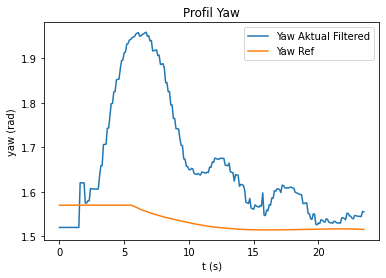

In [10]:
#plt.plot(cs_t, cs_error_yaw)
plt.plot(cs_t - cs_t[0], cs_actual_yaw, label='Yaw Aktual Filtered')
plt.plot(cs_t - cs_t[0], cs_ref_yaw, label='Yaw Ref')
plt.legend()
plt.xlabel('t (s)')
plt.ylabel('yaw (rad)')
plt.title('Profil Yaw')
plt.savefig('images/profil_yaw_kanan.png', dpi=600, transparent=True)
plt.show()

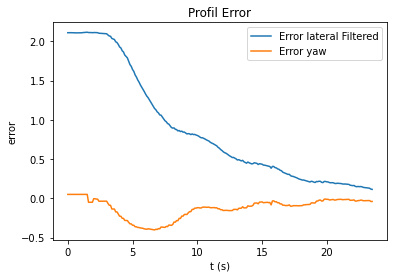

In [11]:
plt.plot(cs_t - cs_t[0], cs_error_lateral, label='Error lateral Filtered')
plt.plot(cs_t - cs_t[0], cs_error_yaw, label='Error yaw')
plt.legend()
plt.xlabel('t (s)')
plt.ylabel('error')
plt.title('Profil Error')
plt.savefig('images/profil_error_kanan.png', dpi=600, transparent=True)
plt.show()

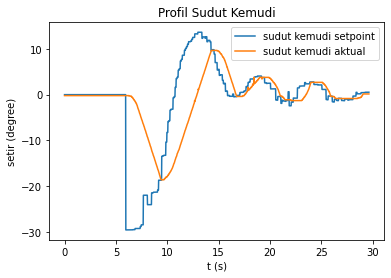

In [12]:
plt.plot(a_t - a_t[0], a_steering_setpoint, label='sudut kemudi setpoint')
plt.plot(a_t - a_t[0], a_steering_angle, label='sudut kemudi aktual')
plt.legend()
plt.xlabel('t (s)')
plt.ylabel('setir (degree)')
plt.title('Profil Sudut Kemudi')
plt.savefig('images/profil_setir_kanan.png', dpi=600, transparent=True)
plt.show()

In [13]:
a_throttle_voltage / 4096 * 5

array([0.        , 0.        , 0.        , ..., 0.37475586, 0.37475586,
       0.37475586])